# Table of Content <a class="anchor" id="content"></a>
- [Imports](#Imports)
- [Data Read-in](#data)
- [Build Model](#Build-Model)
- [Predicition](#prediction)

# Imports<a class="anchor" id="Imports"></a>
[back to top](#content)

In [1]:
import bambi.backend.links
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from scipy.stats import multivariate_normal, wishart
from bambi import Model, Prior
import pymc3 as pm
import pickle

# Data Read-in <a class="anchor" id="data"></a>
[back to top](#content)

In [2]:
root = "../data/"
# load clean data without NA values
surNoNA = (pd.read_csv(root+"survCleanWithSameCols.csv", index_col=0).sort_values(["year", "sitecode"])
              .drop(['race7', 'stheight', 'stweight', 'qnobese'], axis=1))
print('The shape of the dataset without NAs has {:,} rows,{} columns'.format(surNoNA.shape[0],surNoNA.shape[1]))

The shape of the dataset without NAs has 108,151 rows,15 columns


In [4]:
# split data
train_data = surNoNA.query("year == 2011 | year == 2013 | year == 2015")
test_data = surNoNA.query("year == 2019")
train_data.carRiskScore.describe()

count    35898.000000
mean        69.149872
std        108.181743
min          0.000000
25%          0.000000
50%         26.315789
75%        105.263158
max       1000.000000
Name: carRiskScore, dtype: float64

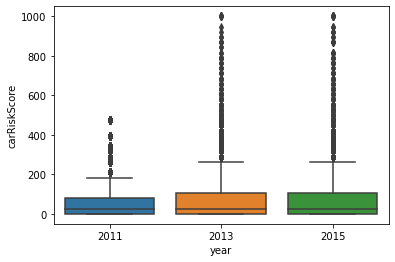

In [5]:
# plot Boxplot to see the distribution
_ = sns.boxplot(x = train_data['year'], y = train_data['carRiskScore'])

# Build group specific model Model <a class="anchor" id="Build-Model"></a>
[back to top](#content)

In [6]:
dat.columns

NameError: name 'dat' is not defined

In [7]:
seed = 551
percent98 = surNoNA.carRiskScore.quantile(.98)
dat = surNoNA.query("carRiskScore < @percent98 & year < 2017").sample(1000, random_state = seed)
dat.loc[:,"carRiskScore"] = dat["carRiskScore"] + 1
county_idxs, counties = pd.factorize(dat["sitecode"]) # transform to numerical values
year_idxs, years = pd.factorize(dat["year"])
coords = {
    "county": counties,
    "years":years,
    "obs_id": np.arange(len(county_idxs))
}

In [8]:
num_group = len(counties)
# X_train = dat.drop(['carRiskScore'], axis = 1)
# test on toy model on two variables 'bmi' and 'age'
train = dat[['age','year','sitecode','carRiskScore', 'bmi','q13','q18','q25','q26','q47','q57']]
train['sitecode'] = county_idxs
train.head()

<ipython-input-8-21e6f4541fdd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['sitecode'] = county_idxs


age  year  sitecode  carRiskScore        bmi  q13  q18  q25  q26  q47  \
292471  4.0  2011         0     79.947368  19.633715  1.0  1.0  2.0  2.0  1.0   
141316  7.0  2005         1     27.315789  22.113573  1.0  1.0  2.0  2.0  1.0   
310164  3.0  2013         2    132.578947  19.757606  1.0  1.0  1.0  1.0  1.0   
123326  4.0  2005         3      1.000000  25.490114  1.0  1.0  2.0  2.0  1.0   
263908  5.0  2011         4      1.000000  24.545265  1.0  1.0  2.0  2.0  1.0   

        q57  
292471  2.0  
141316  2.0  
310164  2.0  
123326  2.0  
263908  2.0

# Full Model

In [9]:
# set up full model prior
grp_mean = Prior("Normal",mu = 10, sigma = 10)
grp_sd = Prior("HalfCauchy", beta= 5)
default_prior = Prior("Normal", mu=grp_mean, sigma=grp_sd)
priors = {
    "Intercept": Prior("Normal", mu = train.carRiskScore.mean(), sigma = train.carRiskScore.std()),
    "bmi": Prior("Normal", mu = train.bmi.mean(), sigma = train.bmi.std()),
    "age": Prior("Normal", mu = train.age.mean(), sigma = train.age.std()),
    "age|sitecode": default_prior
}
# add in questions as variables
for i in ['q13','q18','q25','q26','q47','q57']:
    var_name = i + '|sitecode'
    priors[var_name] = default_prior
# fit fullmodel
model = Model(
    "carRiskScore ~  bmi + age + (age|sitecode) + (q13|sitecode) + (q18|sitecode) + (q25|sitecode) + (q26|sitecode) + (q47|sitecode) + (q57|sitecode)" ,
    train,
    priors=priors
)
results = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [carRiskScore_sigma, q57|sitecode_offset, q57|sitecode_sigma, q57|sitecode_mu, q47|sitecode_offset, q47|sitecode_sigma, q47|sitecode_mu, q26|sitecode_offset, q26|sitecode_sigma, q26|sitecode_mu, q25|sitecode_offset, q25|sitecode_sigma, q25|sitecode_mu, q18|sitecode_offset, q18|sitecode_sigma, q18|sitecode_mu, q13|sitecode_offset, q13|sitecode_sigma, q13|sitecode_mu, age|sitecode_offset, age|sitecode_sigma, age|sitecode_mu, 1|sitecode_offset, 1|sitecode_sigma, age, bmi, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 182 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


# Full model diagnostic

In [9]:
az.summary(results)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept           24.156  14.663  -3.422   51.193      0.237    0.187   
bmi                  0.093   0.561  -0.984    1.128      0.009    0.010   
age                  4.197   1.046   2.287    6.255      0.016    0.012   
age|sitecode_mu     10.158  10.167  -8.858   28.950      0.158    0.137   
q13|sitecode_mu      9.805  10.204 -10.037   28.282      0.173    0.145   
...                    ...     ...     ...      ...        ...      ...   
q57|sitecode[19]    -0.135   3.629  -6.890    7.650      0.068    0.058   
q57|sitecode[20]     0.368   3.796  -6.969    8.464      0.084    0.065   
q57|sitecode[21]     0.723   3.880  -6.622    8.473      0.073    0.056   
q57|sitecode[22]    -0.114   3.912  -7.955    7.612      0.071    0.063   
carRiskScore_sigma  74.143   1.704  71.096   77.436      0.031    0.022   

                    ess_bulk  ess_tail  r_hat  
Intercept             3808.0    2624.0    1.0  
bmi                   3874.0    2526.0    1.0  
age                   4291.0    2103.0    1.0  
age|sitecode_mu       4104.0    2196.0    1.0  
q13|sitecode_mu       3464.0    2487.0    1.0  
...                      ...       ...    ...  
q57|sitecode[19]      2865.0    2482.0    1.0  
q57|sitecode[20]      2411.0    1900.0    1.0  
q57|sitecode[21]      2855.0    2055.0    1.0  
q57|sitecode[22]      3234.0    2650.0    1.0  
carRiskScore_sigma    2948.0    2184.0    1.0  

[203 rows x 9 columns]

/Users/tangsw/opt/anaconda3/envs/umich/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/pairplot.py:238: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


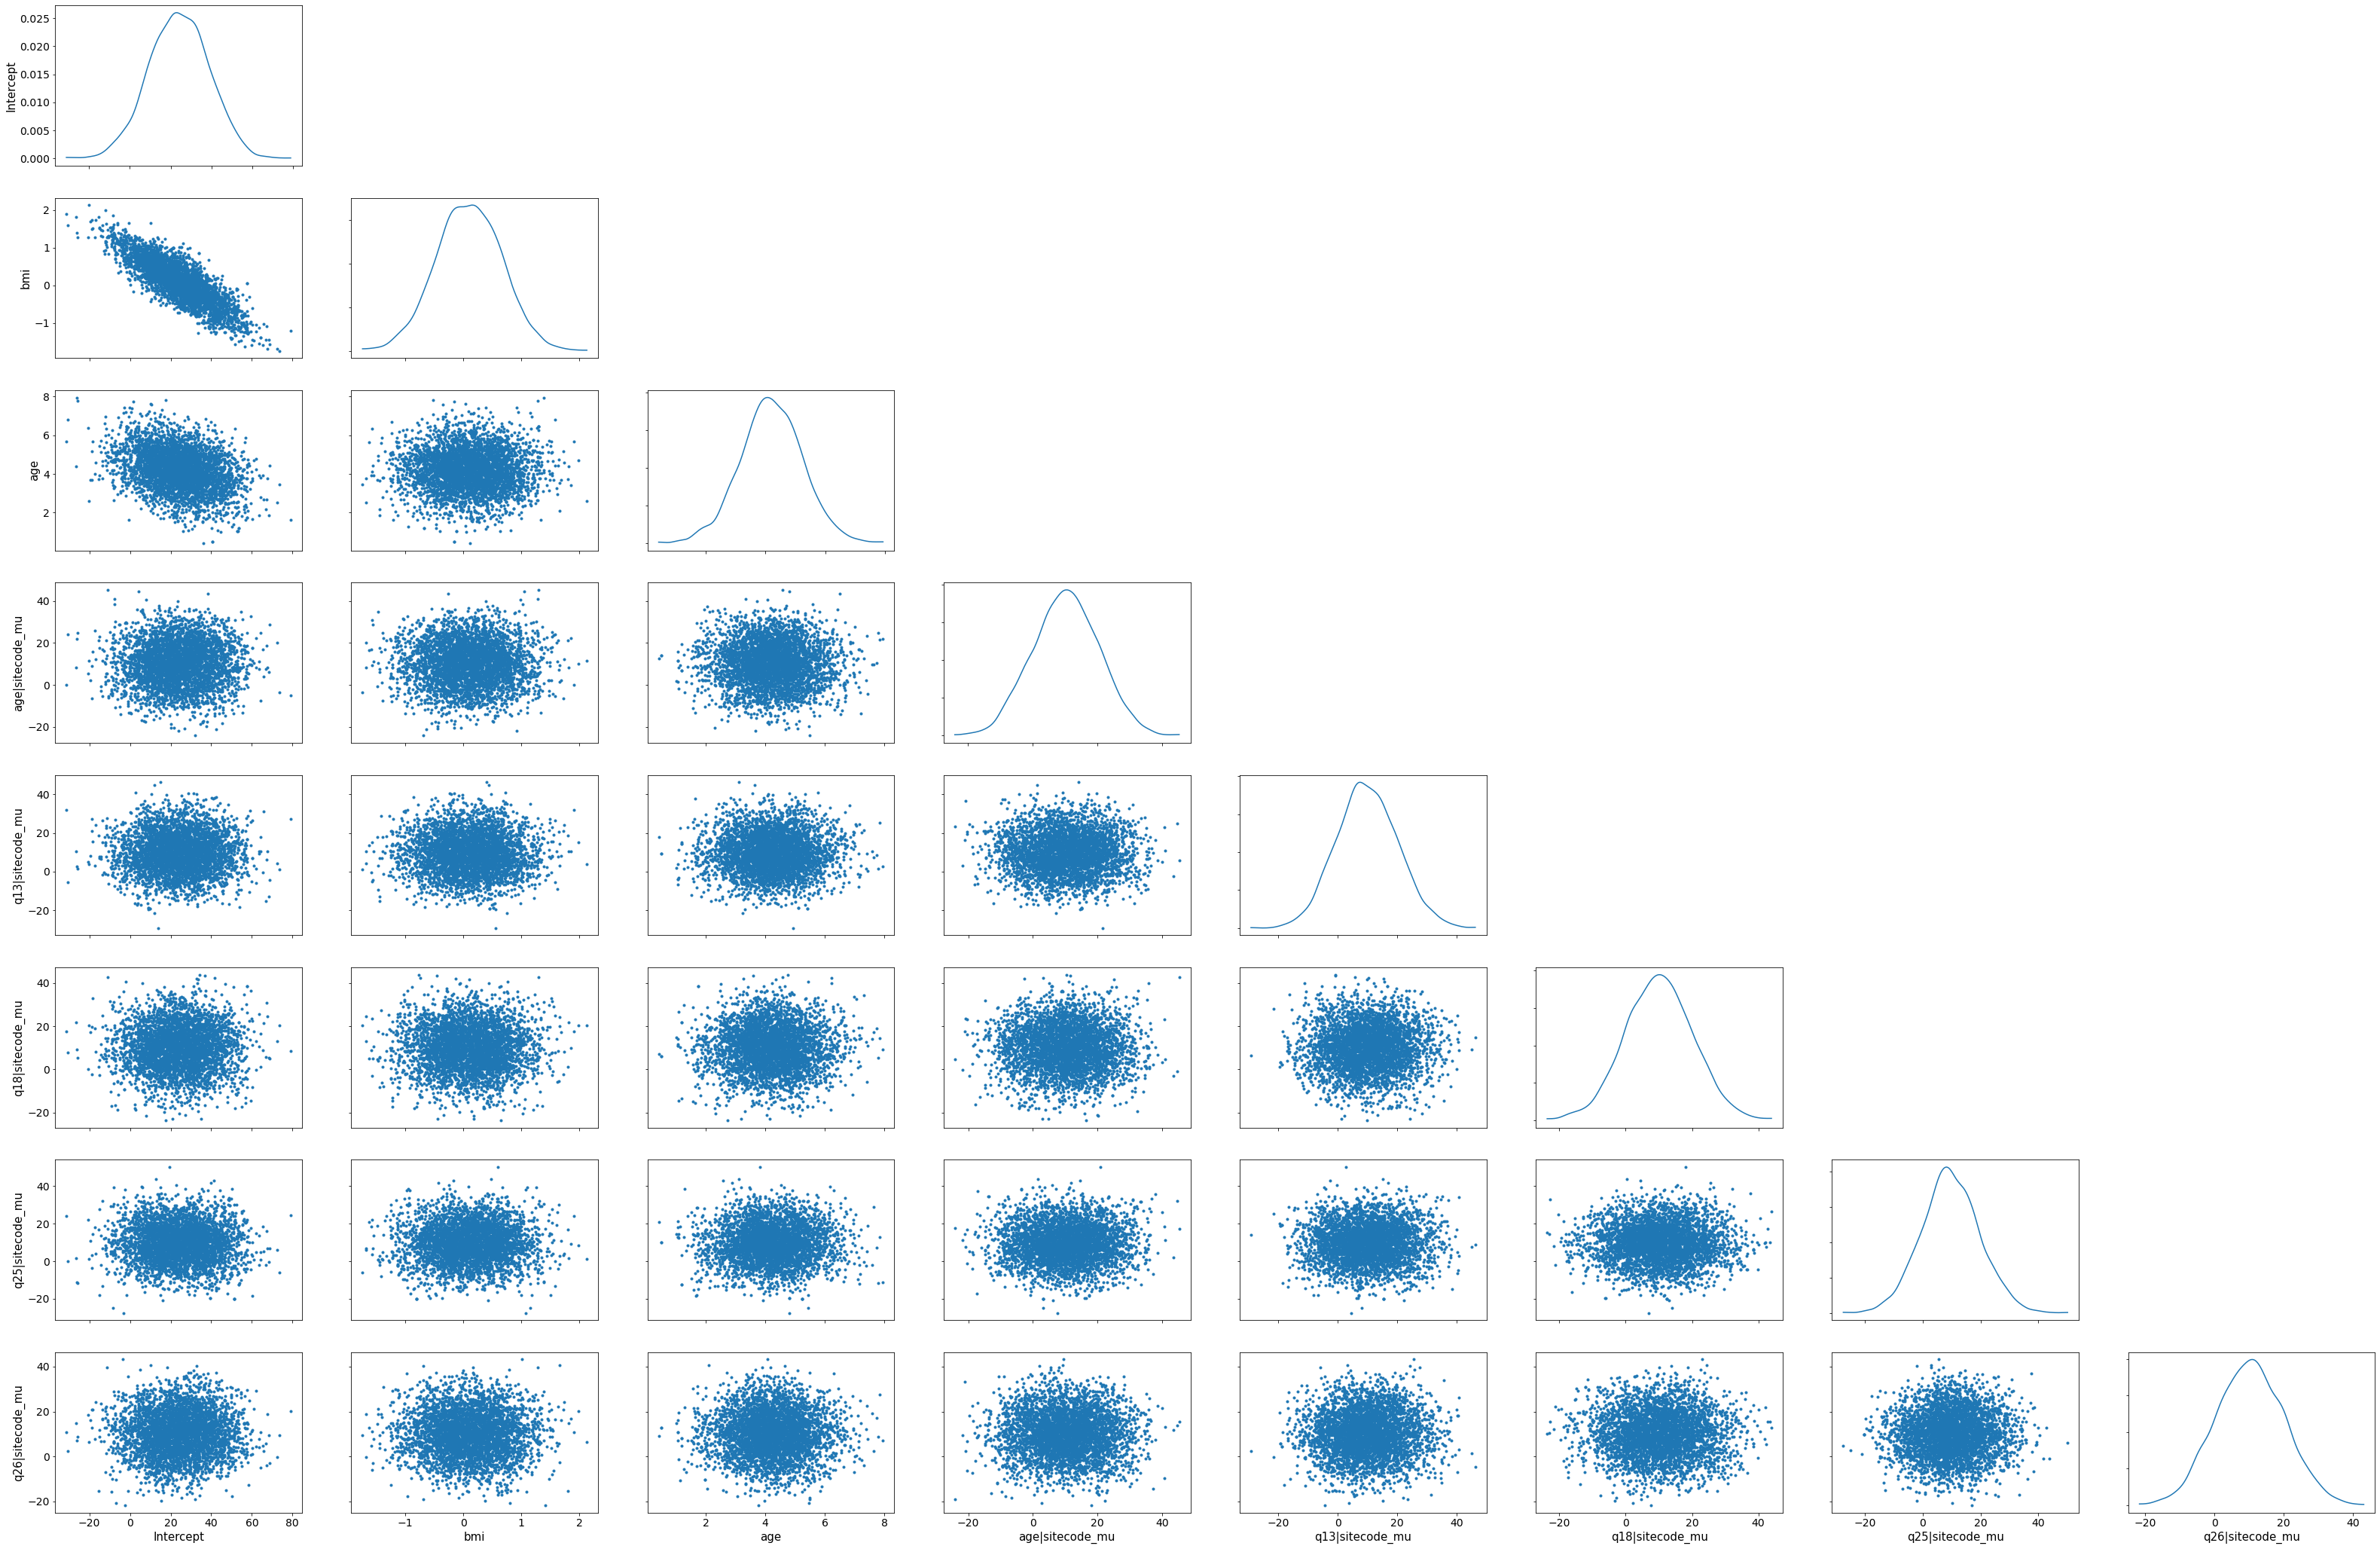

In [10]:
az.plot_pair(results, marginals=True)

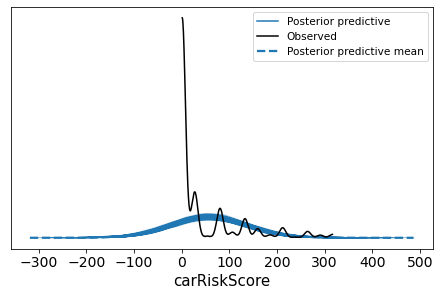

In [11]:
posterior_predictive = model.predict(results, kind="pps", draws=500)
_ = az.plot_ppc(results)

/Users/tangsw/opt/anaconda3/envs/umich/lib/python3.9/site-packages/arviz/plots/plot_utils.py:490: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (203) in plot_posterior, generating only 40 plots
  warnings.warn(


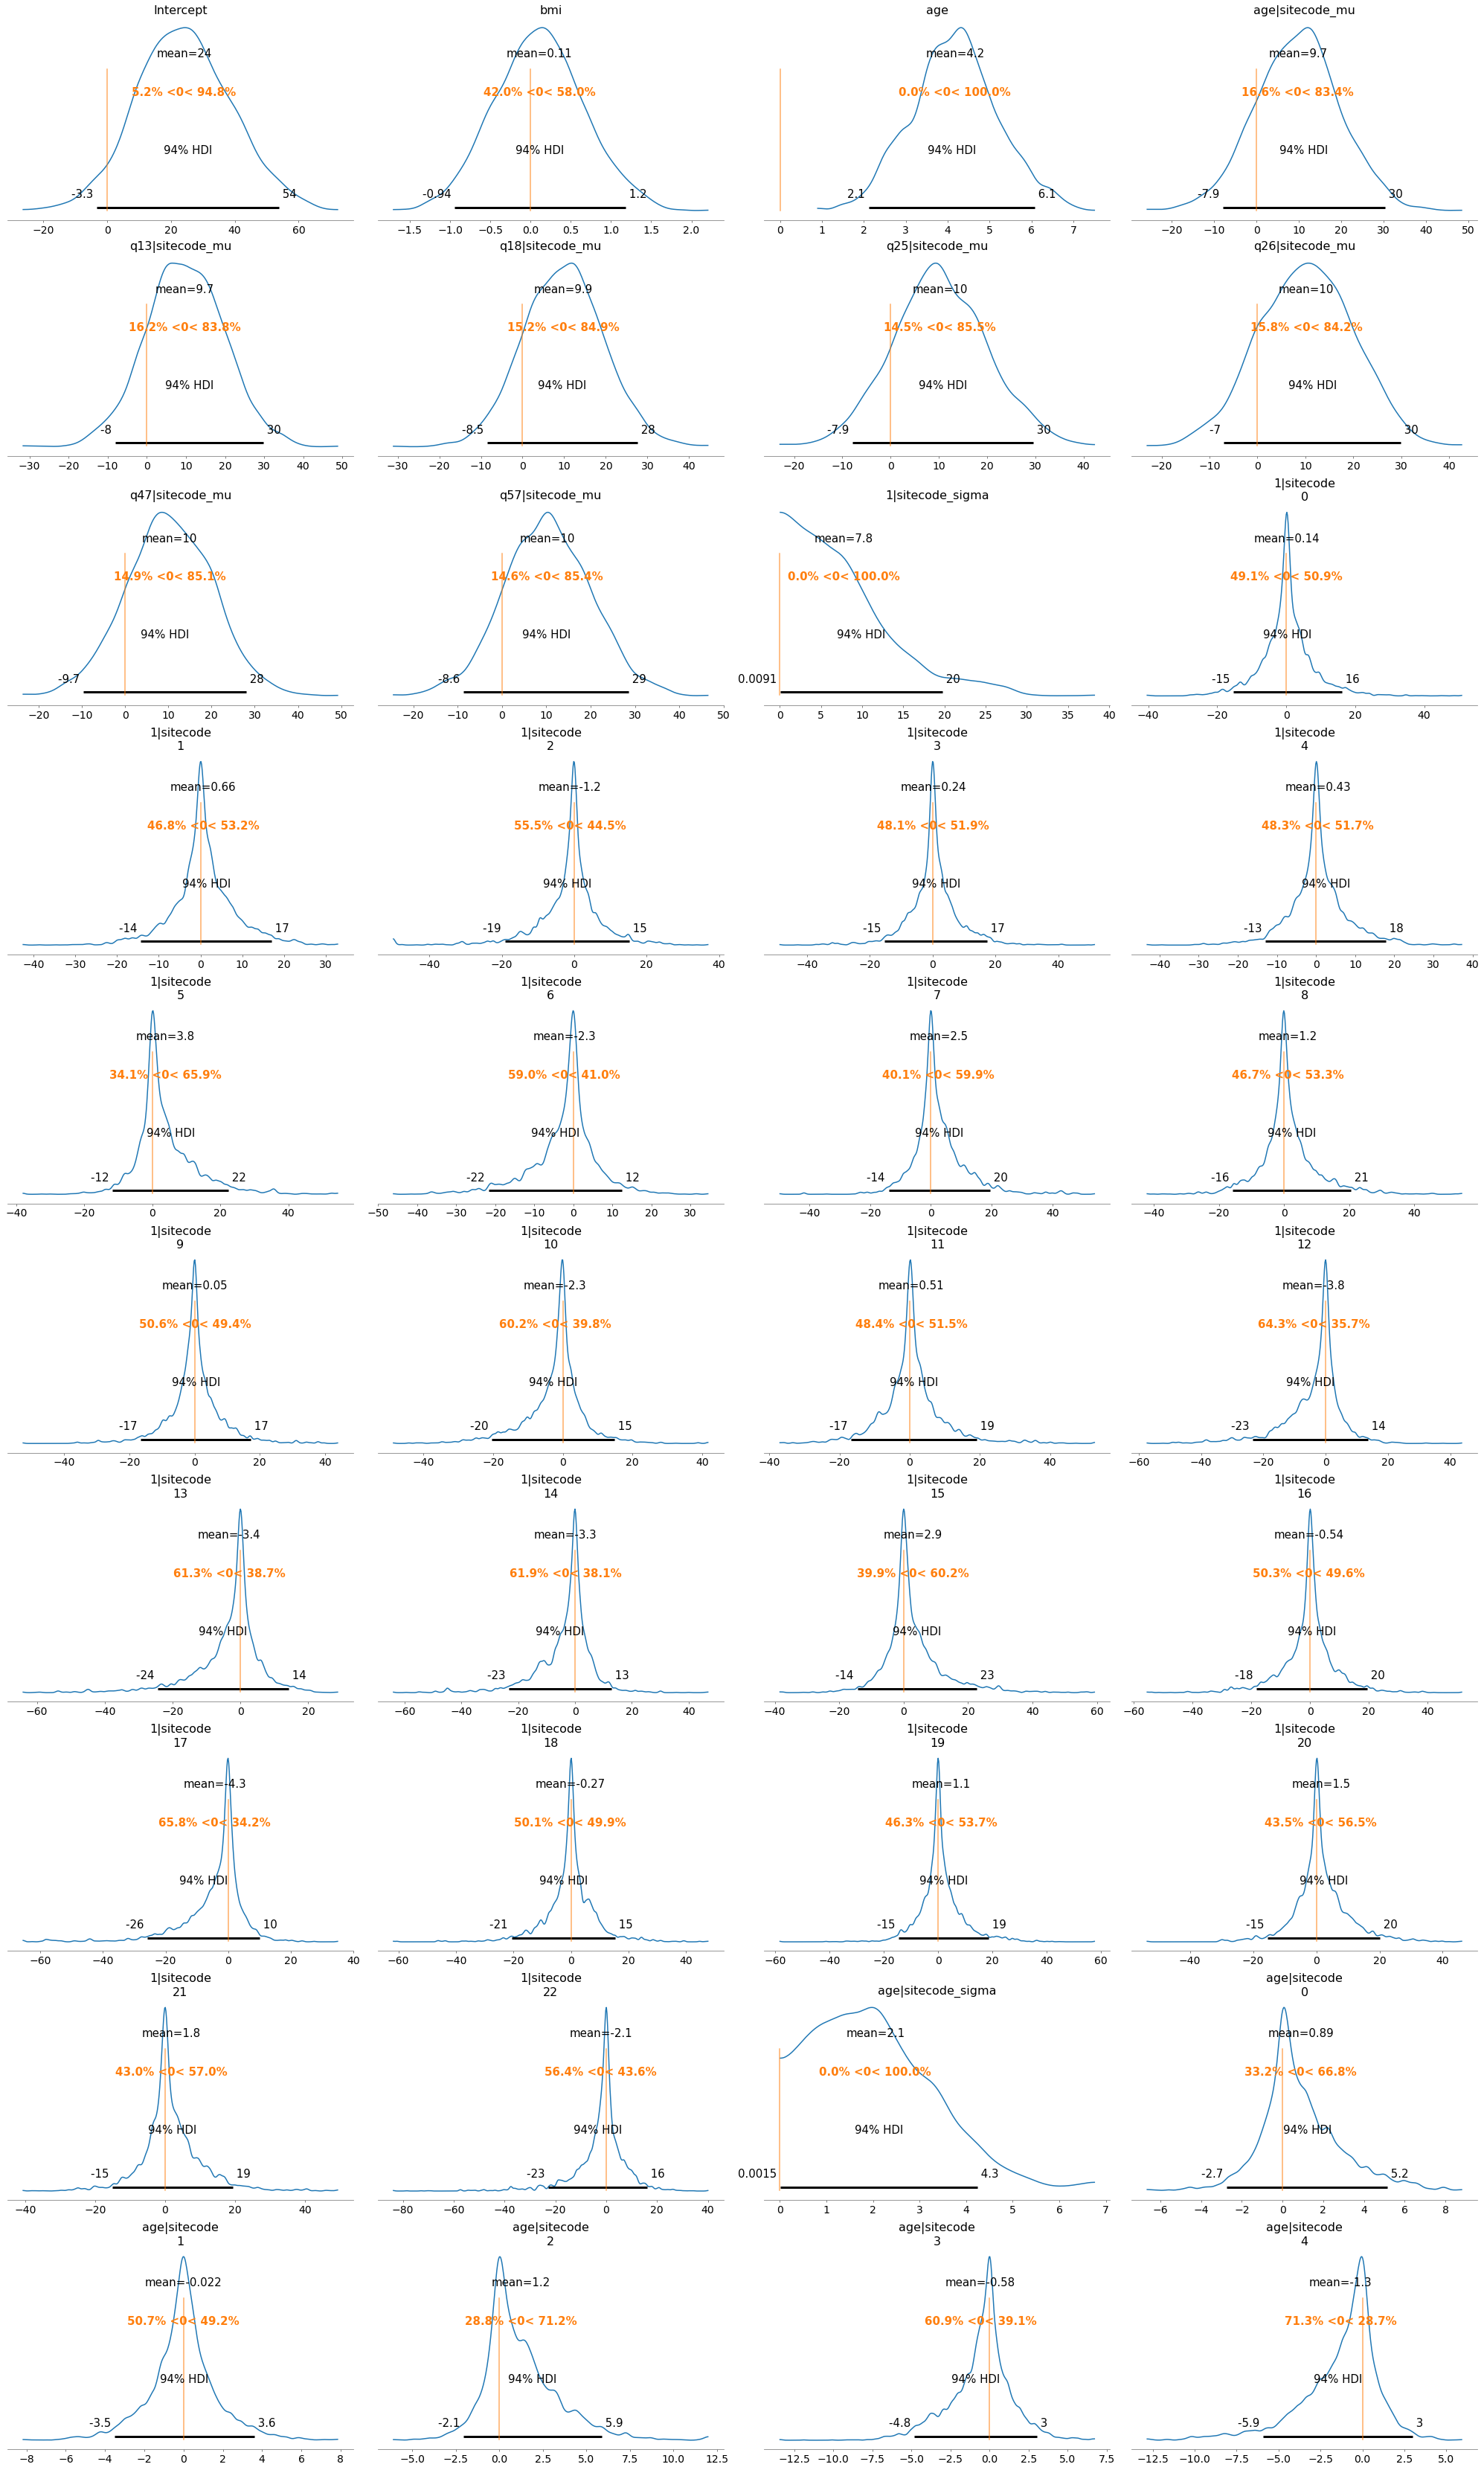

In [12]:
az.plot_posterior(results, ref_val=0);

/Users/tangsw/opt/anaconda3/envs/umich/lib/python3.9/site-packages/arviz/plots/traceplot.py:197: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (27), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'bmi'}>,
        <AxesSubplot:title={'center':'bmi'}>],
       [<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'age|sitecode_mu'}>,
        <AxesSubplot:title={'center':'age|sitecode_mu'}>],
       [<AxesSubplot:title={'center':'q13|sitecode_mu'}>,
        <AxesSubplot:title={'center':'q13|sitecode_mu'}>],
       [<AxesSubplot:title={'center':'q18|sitecode_mu'}>,
        <AxesSubplot:title={'center':'q18|sitecode_mu'}>],
       [<AxesSubplot:title={'center':'q25|sitecode_mu'}>,
        <AxesSubplot:title={'center':'q25|sitecode_mu'}>],
       [<AxesSubplot:title={'center':'q26|sitecode_mu'}>,
        <AxesSubplot:title={'center':'q26|sitecode_mu'}>],
       [<AxesSubplot:title={'center':'q47|sitecode_mu'}>,
        <AxesSubplot:title={'center':'q47|sitecode_mu'}>],
       

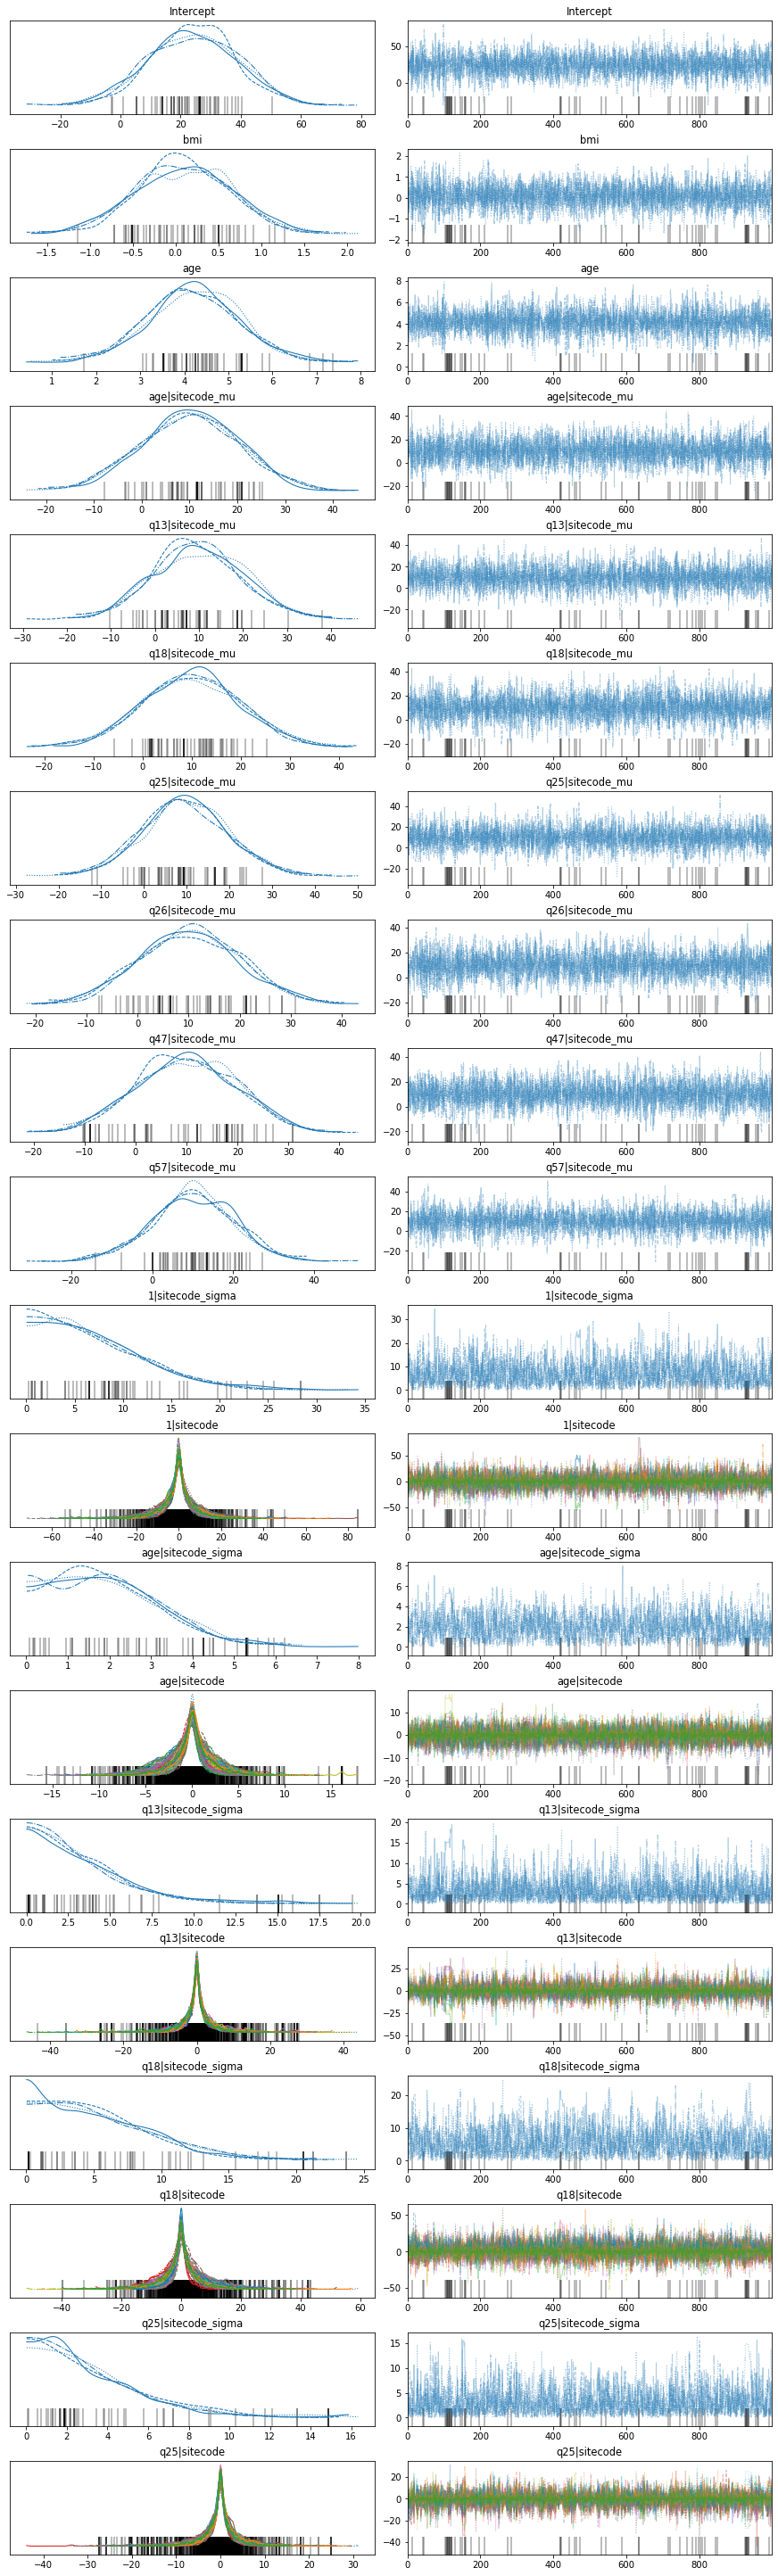

In [16]:
# trace plot, can set var names
az.plot_trace(results)

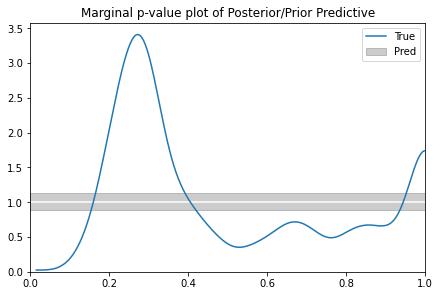

In [16]:
_ = az.plot_bpv(results, kind="u_value")
_ = _.legend(['True','Pred'])
_ = plt.title("Marginal p-value plot of Posterior/Prior Predictive")
plt.savefig('Marginal_p_value.png')

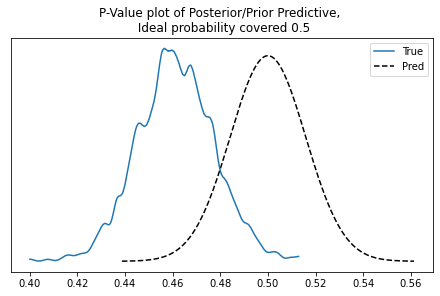

In [20]:
_ = az.plot_bpv(results, kind="p_value")
_ = _.legend(['True','Pred'])
_ = plt.title("P-Value plot of Posterior/Prior Predictive,"
              " \n Ideal probability covered 0.5")
plt.savefig("pvalue.png")

/Users/tangsw/opt/anaconda3/envs/umich/lib/python3.9/site-packages/arviz/plots/plot_utils.py:490: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (203) in plot_rank, generating only 40 plots
  warnings.warn(


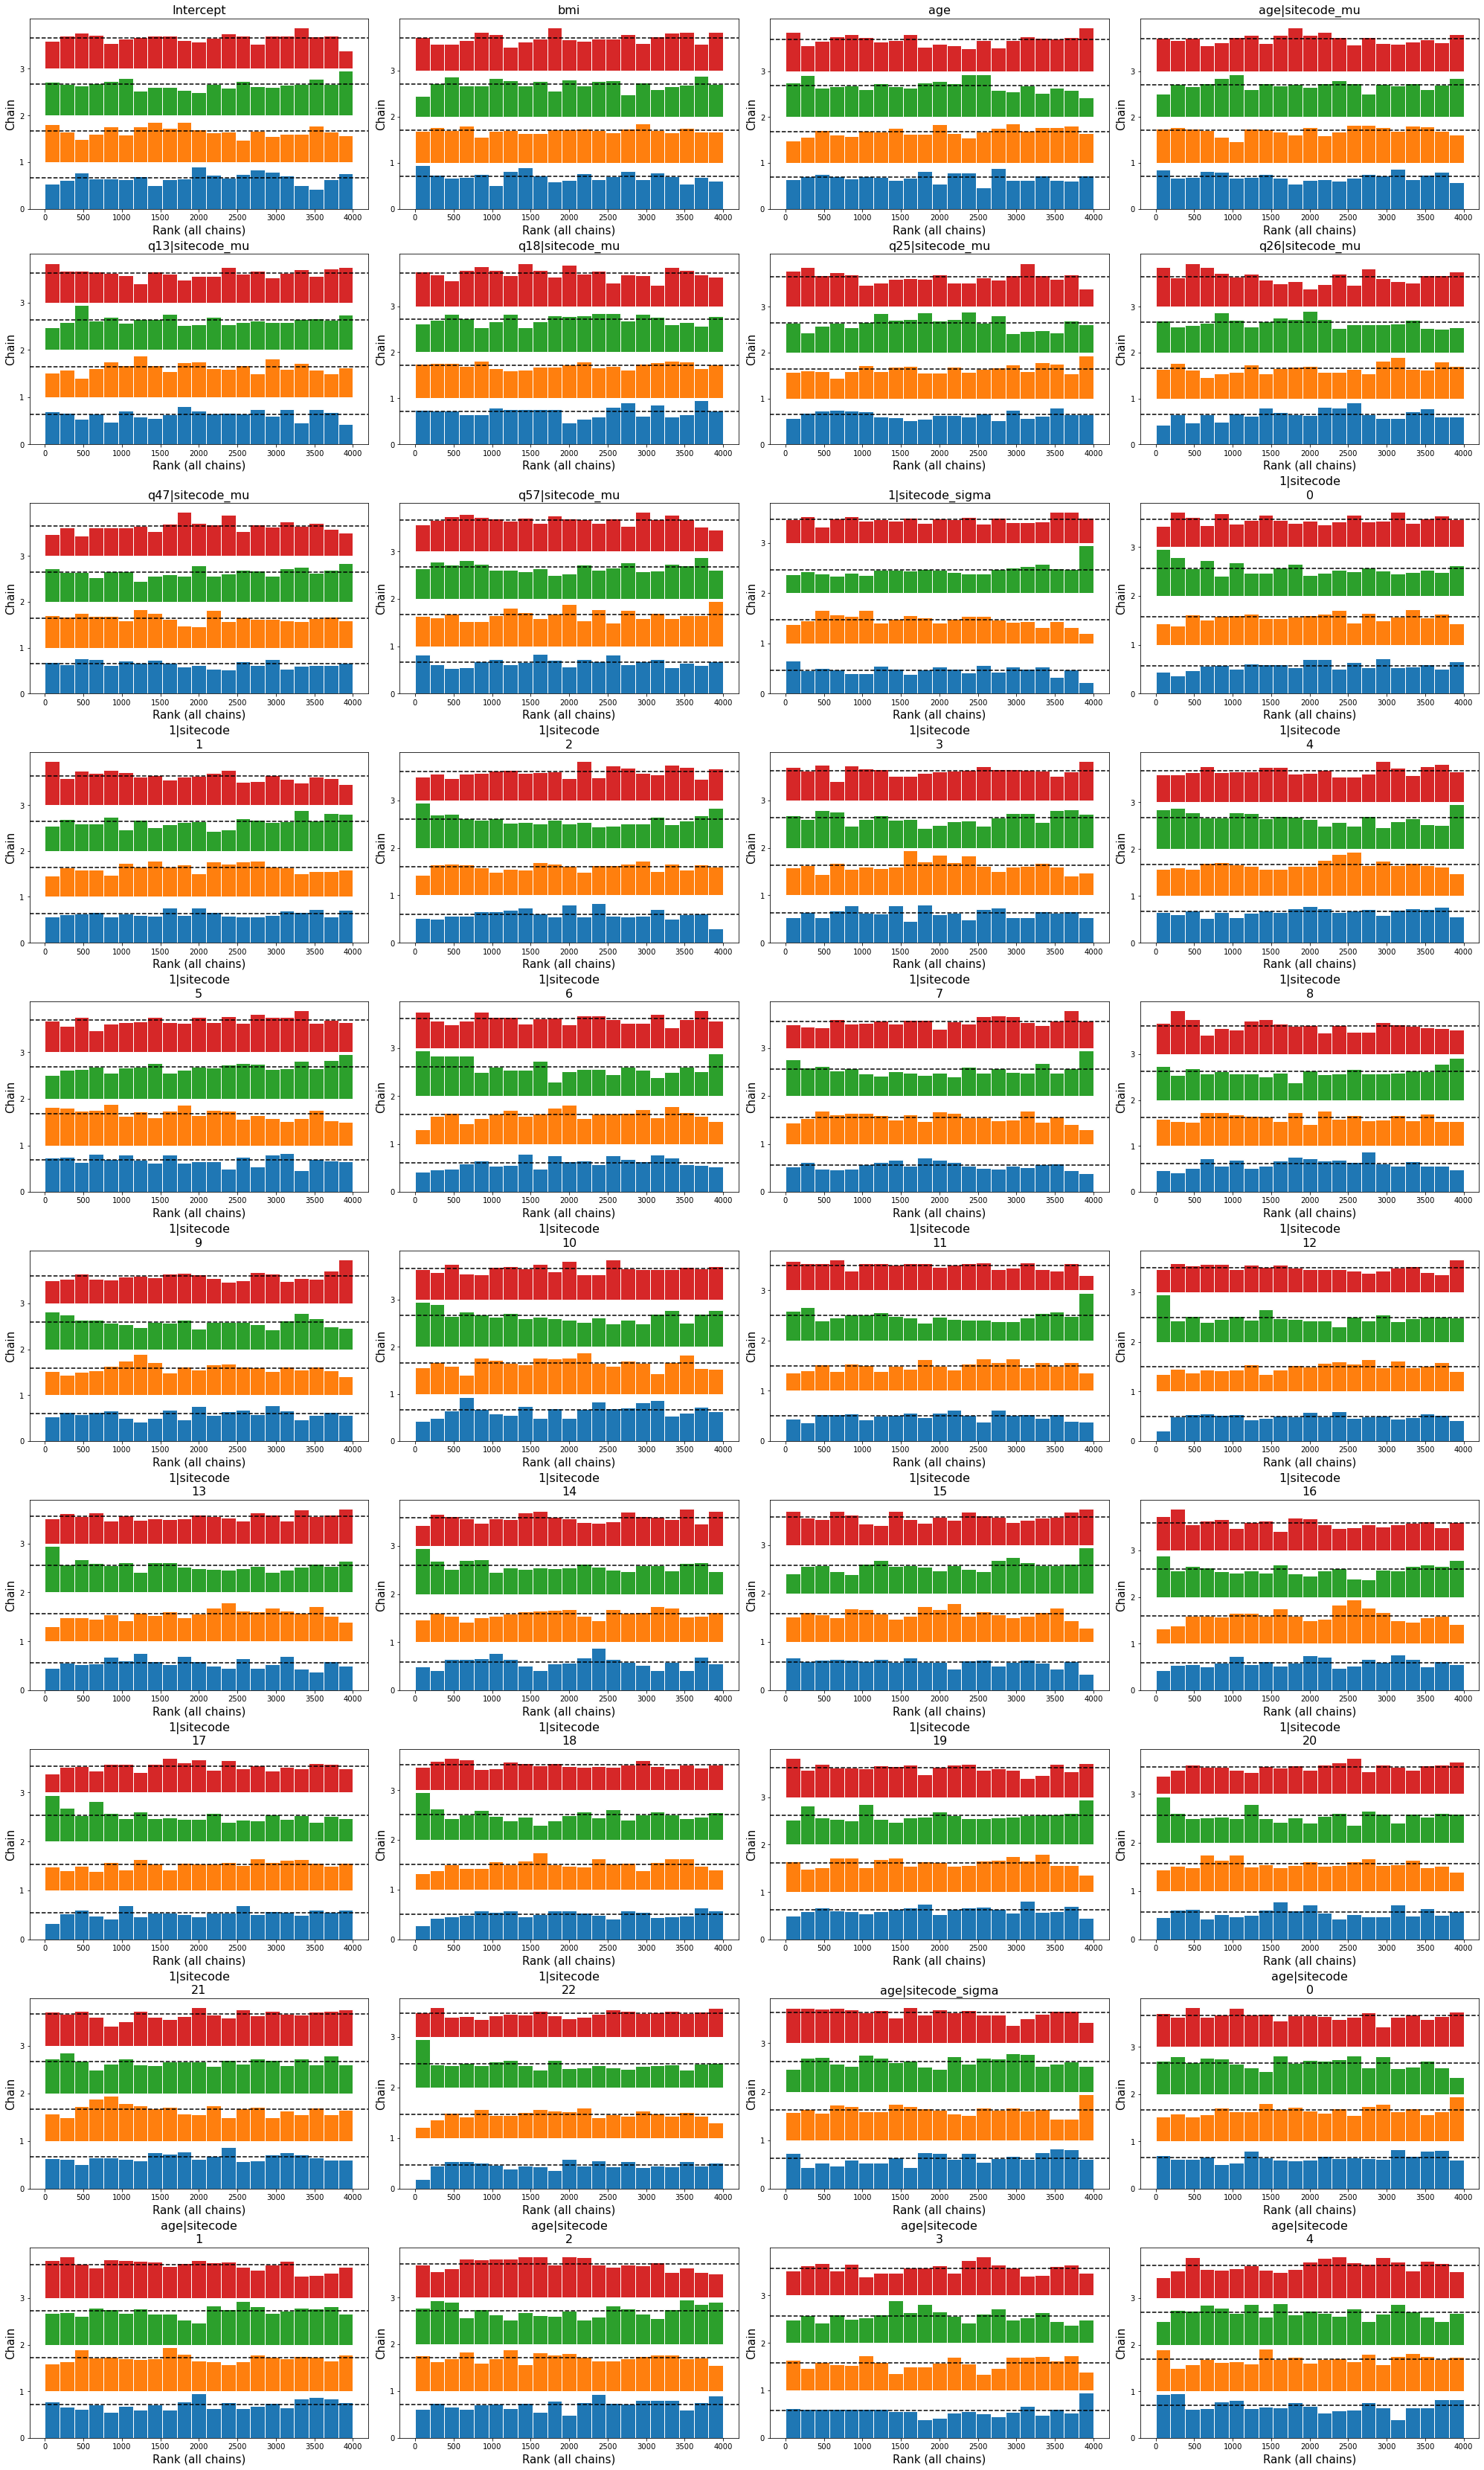

In [18]:
# rank plot
_ = az.plot_rank(results,kind="bars")

# toy model

In [51]:
# set up bambi prior for the toy model
grp_mean = Prior("Normal",mu = 10, sigma = 10)
grp_sd = Prior("HalfCauchy", beta= 5)
default_prior = Prior("Normal", mu=grp_mean, sigma=grp_sd)
priors = {
    "Intercept": Prior("Normal", mu = train.carRiskScore.mean(), sigma = train.carRiskScore.std()),
    "bmi": Prior("Normal", mu = train.bmi.mean(), sigma = train.bmi.std()),
    "age": Prior("Normal", mu = train.age.mean(), sigma = train.age.std()),
    "age|year": default_prior,
    "age|sitecode": default_prior,
    "bmi|year": default_prior,
    "bmi|sitecode": default_prior
}
# fit model
model = Model(
    "carRiskScore ~  bmi + age + (age|sitecode) + (bmi|year) + (age|year) + (bmi|sitecode)",
    train,
    priors=priors
)
results = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [carRiskScore_sigma, bmi|sitecode_offset, bmi|sitecode_sigma, bmi|sitecode_mu, age|year_offset, age|year_sigma, age|year_mu, bmi|year_offset, bmi|year_sigma, bmi|year_mu, 1|year_offset, 1|year_sigma, age|sitecode_offset, age|sitecode_sigma, age|sitecode_mu, 1|sitecode_offset, 1|sitecode_sigma, age, bmi, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 178 seconds.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 161 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6939998319696511, but should be close to 0.8. Try to increase the number of tuning steps.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


/Users/tangsw/opt/anaconda3/envs/umich/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/pairplot.py:238: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


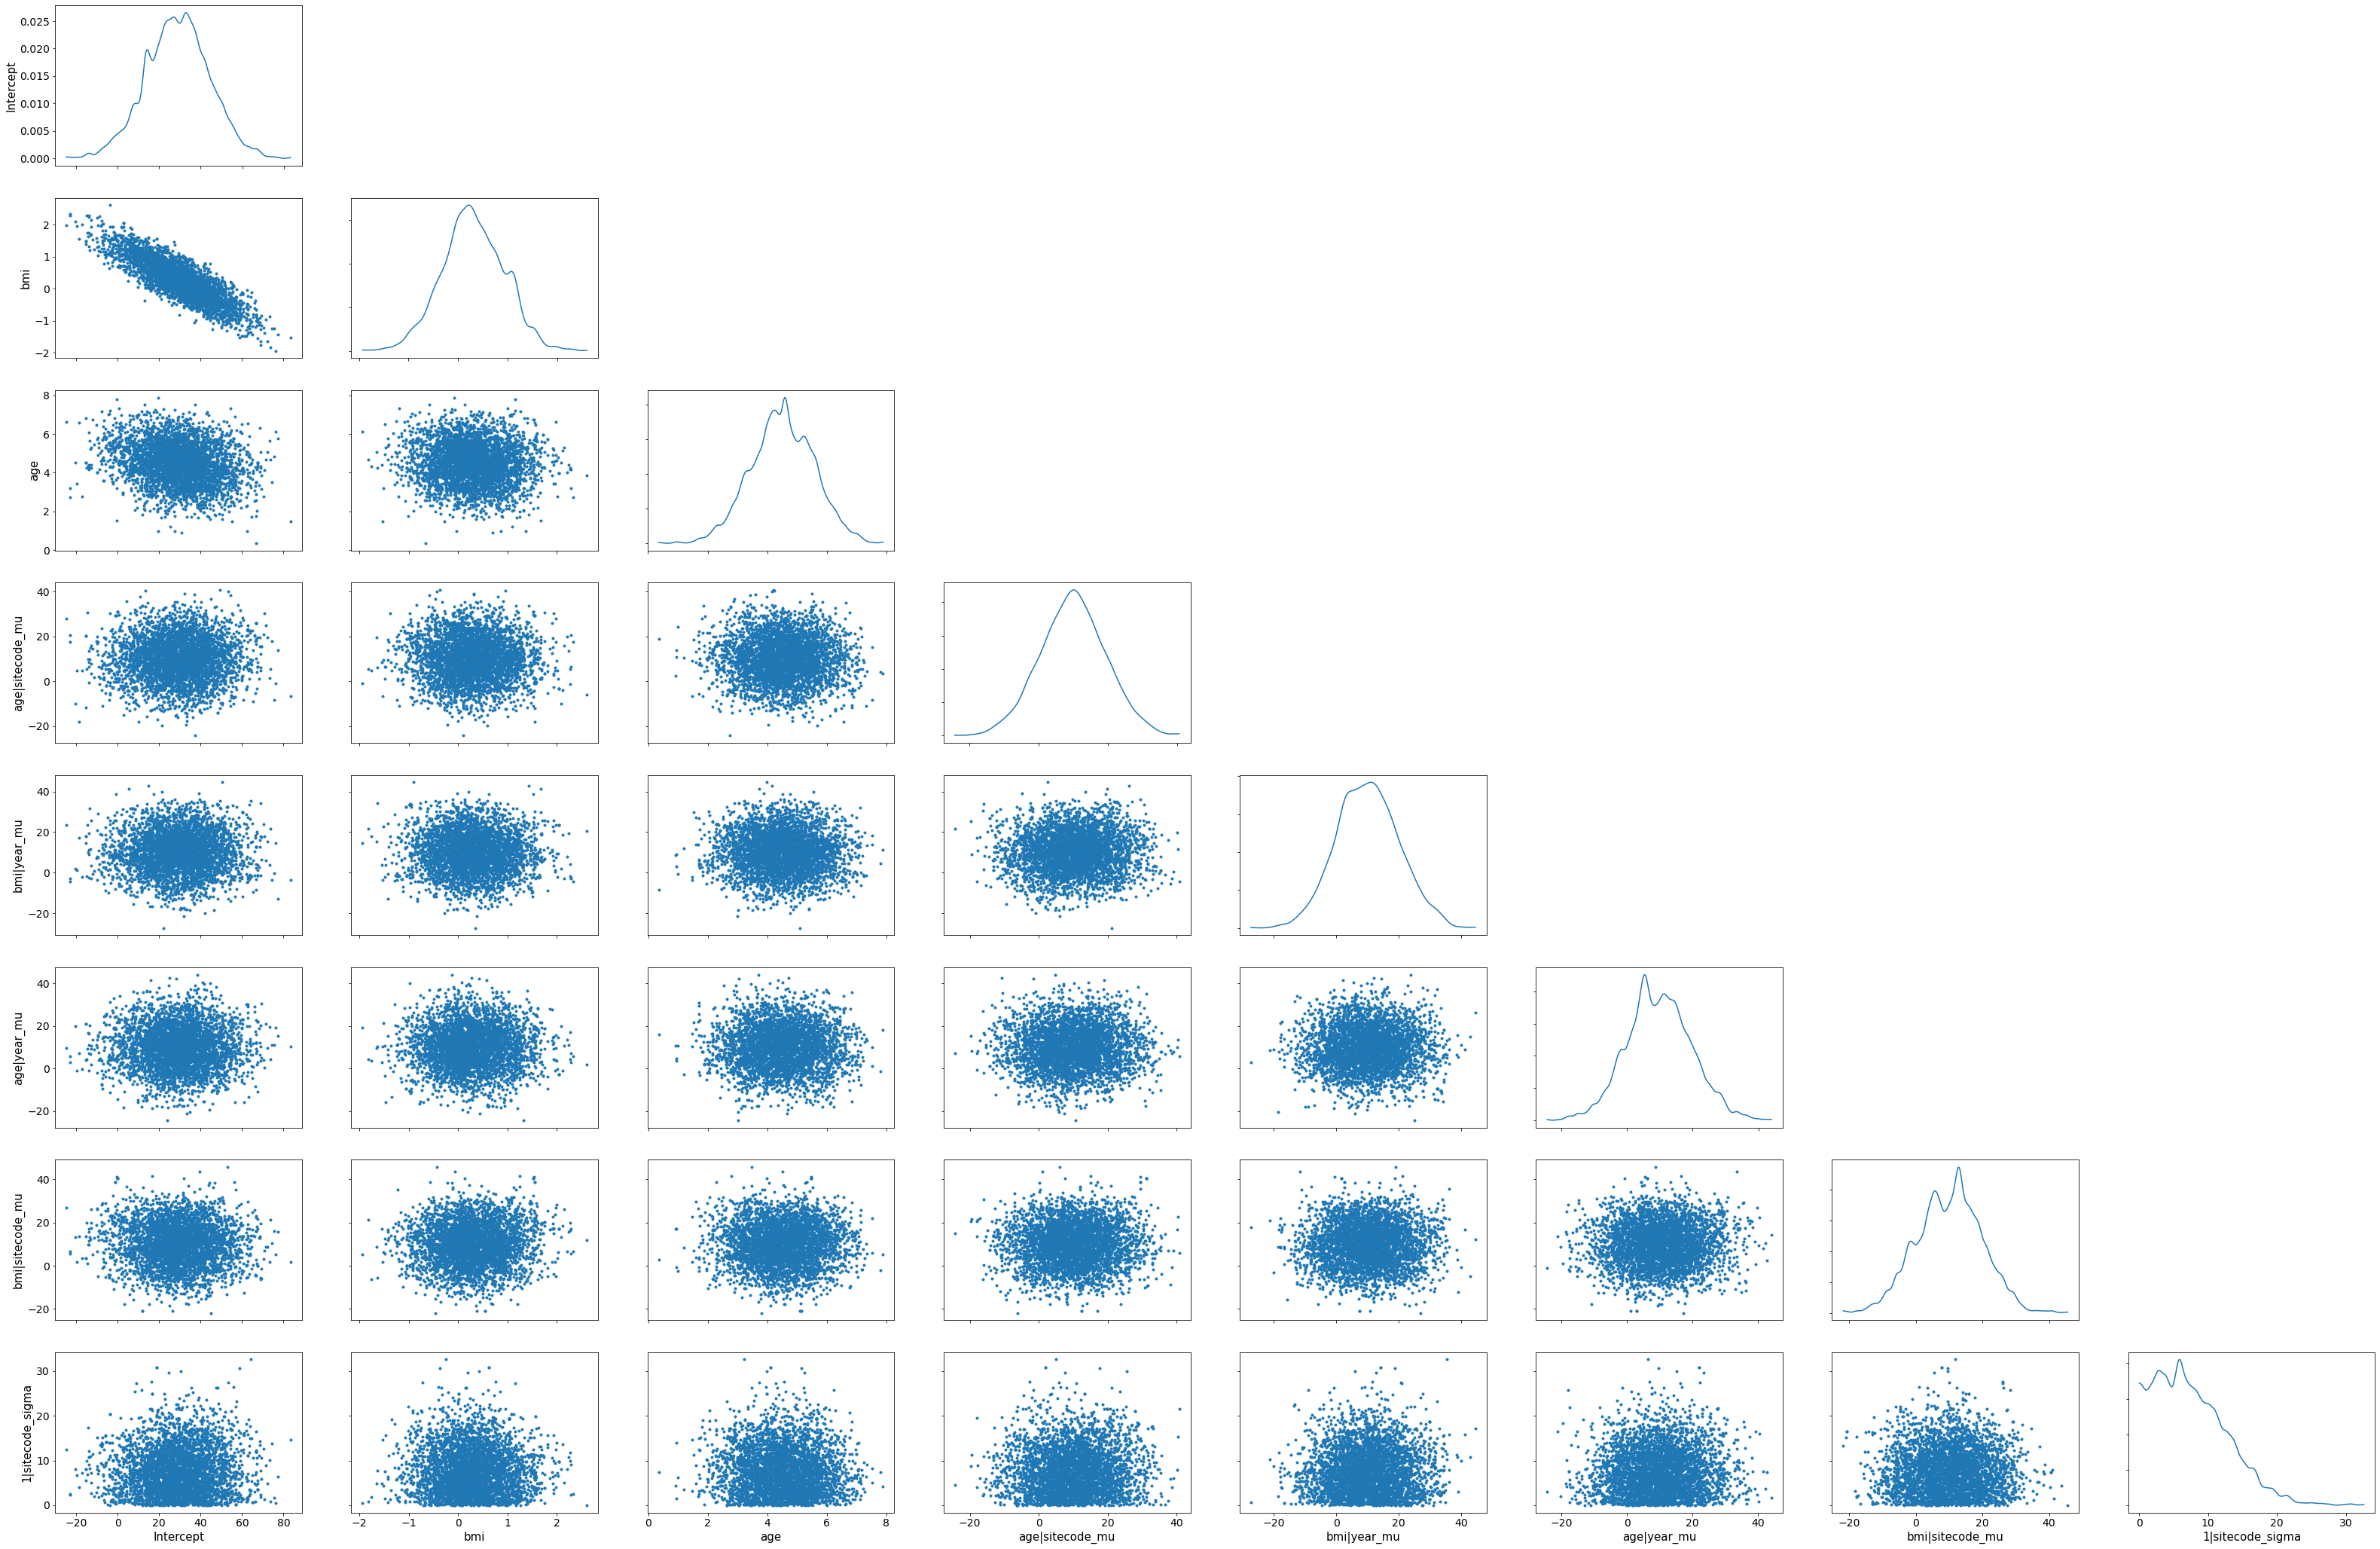

In [52]:
az.plot_pair(results, marginals=True);

In [53]:
az.summary(results)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept           28.911  15.351  -0.906   57.186      0.383    0.271   
bmi                  0.307   0.624  -1.006    1.340      0.020    0.016   
age                  4.500   1.048   2.541    6.465      0.023    0.016   
age|sitecode_mu      9.957   9.437  -9.376   26.540      0.201    0.167   
bmi|year_mu         10.076   9.927  -8.926   28.449      0.263    0.220   
...                    ...     ...     ...      ...        ...      ...   
bmi|sitecode[19]     0.040   0.265  -0.487    0.588      0.006    0.005   
bmi|sitecode[20]     0.036   0.281  -0.533    0.585      0.006    0.005   
bmi|sitecode[21]     0.055   0.277  -0.506    0.603      0.006    0.005   
bmi|sitecode[22]    -0.070   0.309  -0.733    0.518      0.008    0.006   
carRiskScore_sigma  76.130   1.656  73.159   79.451      0.035    0.025   

                    ess_bulk  ess_tail  r_hat  
Intercept             1596.0    1725.0   1.00  
bmi                   1054.0    1324.0   1.00  
age                   2097.0    2036.0   1.00  
age|sitecode_mu       2196.0    2093.0   1.01  
bmi|year_mu           1440.0     931.0   1.01  
...                      ...       ...    ...  
bmi|sitecode[19]      1519.0    2380.0   1.00  
bmi|sitecode[20]      1892.0    1499.0   1.00  
bmi|sitecode[21]      2015.0    1899.0   1.00  
bmi|sitecode[22]      1665.0    1188.0   1.00  
carRiskScore_sigma    2181.0    2154.0   1.01  

[101 rows x 9 columns]

/Users/tangsw/opt/anaconda3/envs/umich/lib/python3.9/site-packages/arviz/plots/plot_utils.py:490: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (101) in plot_posterior, generating only 40 plots
  warnings.warn(


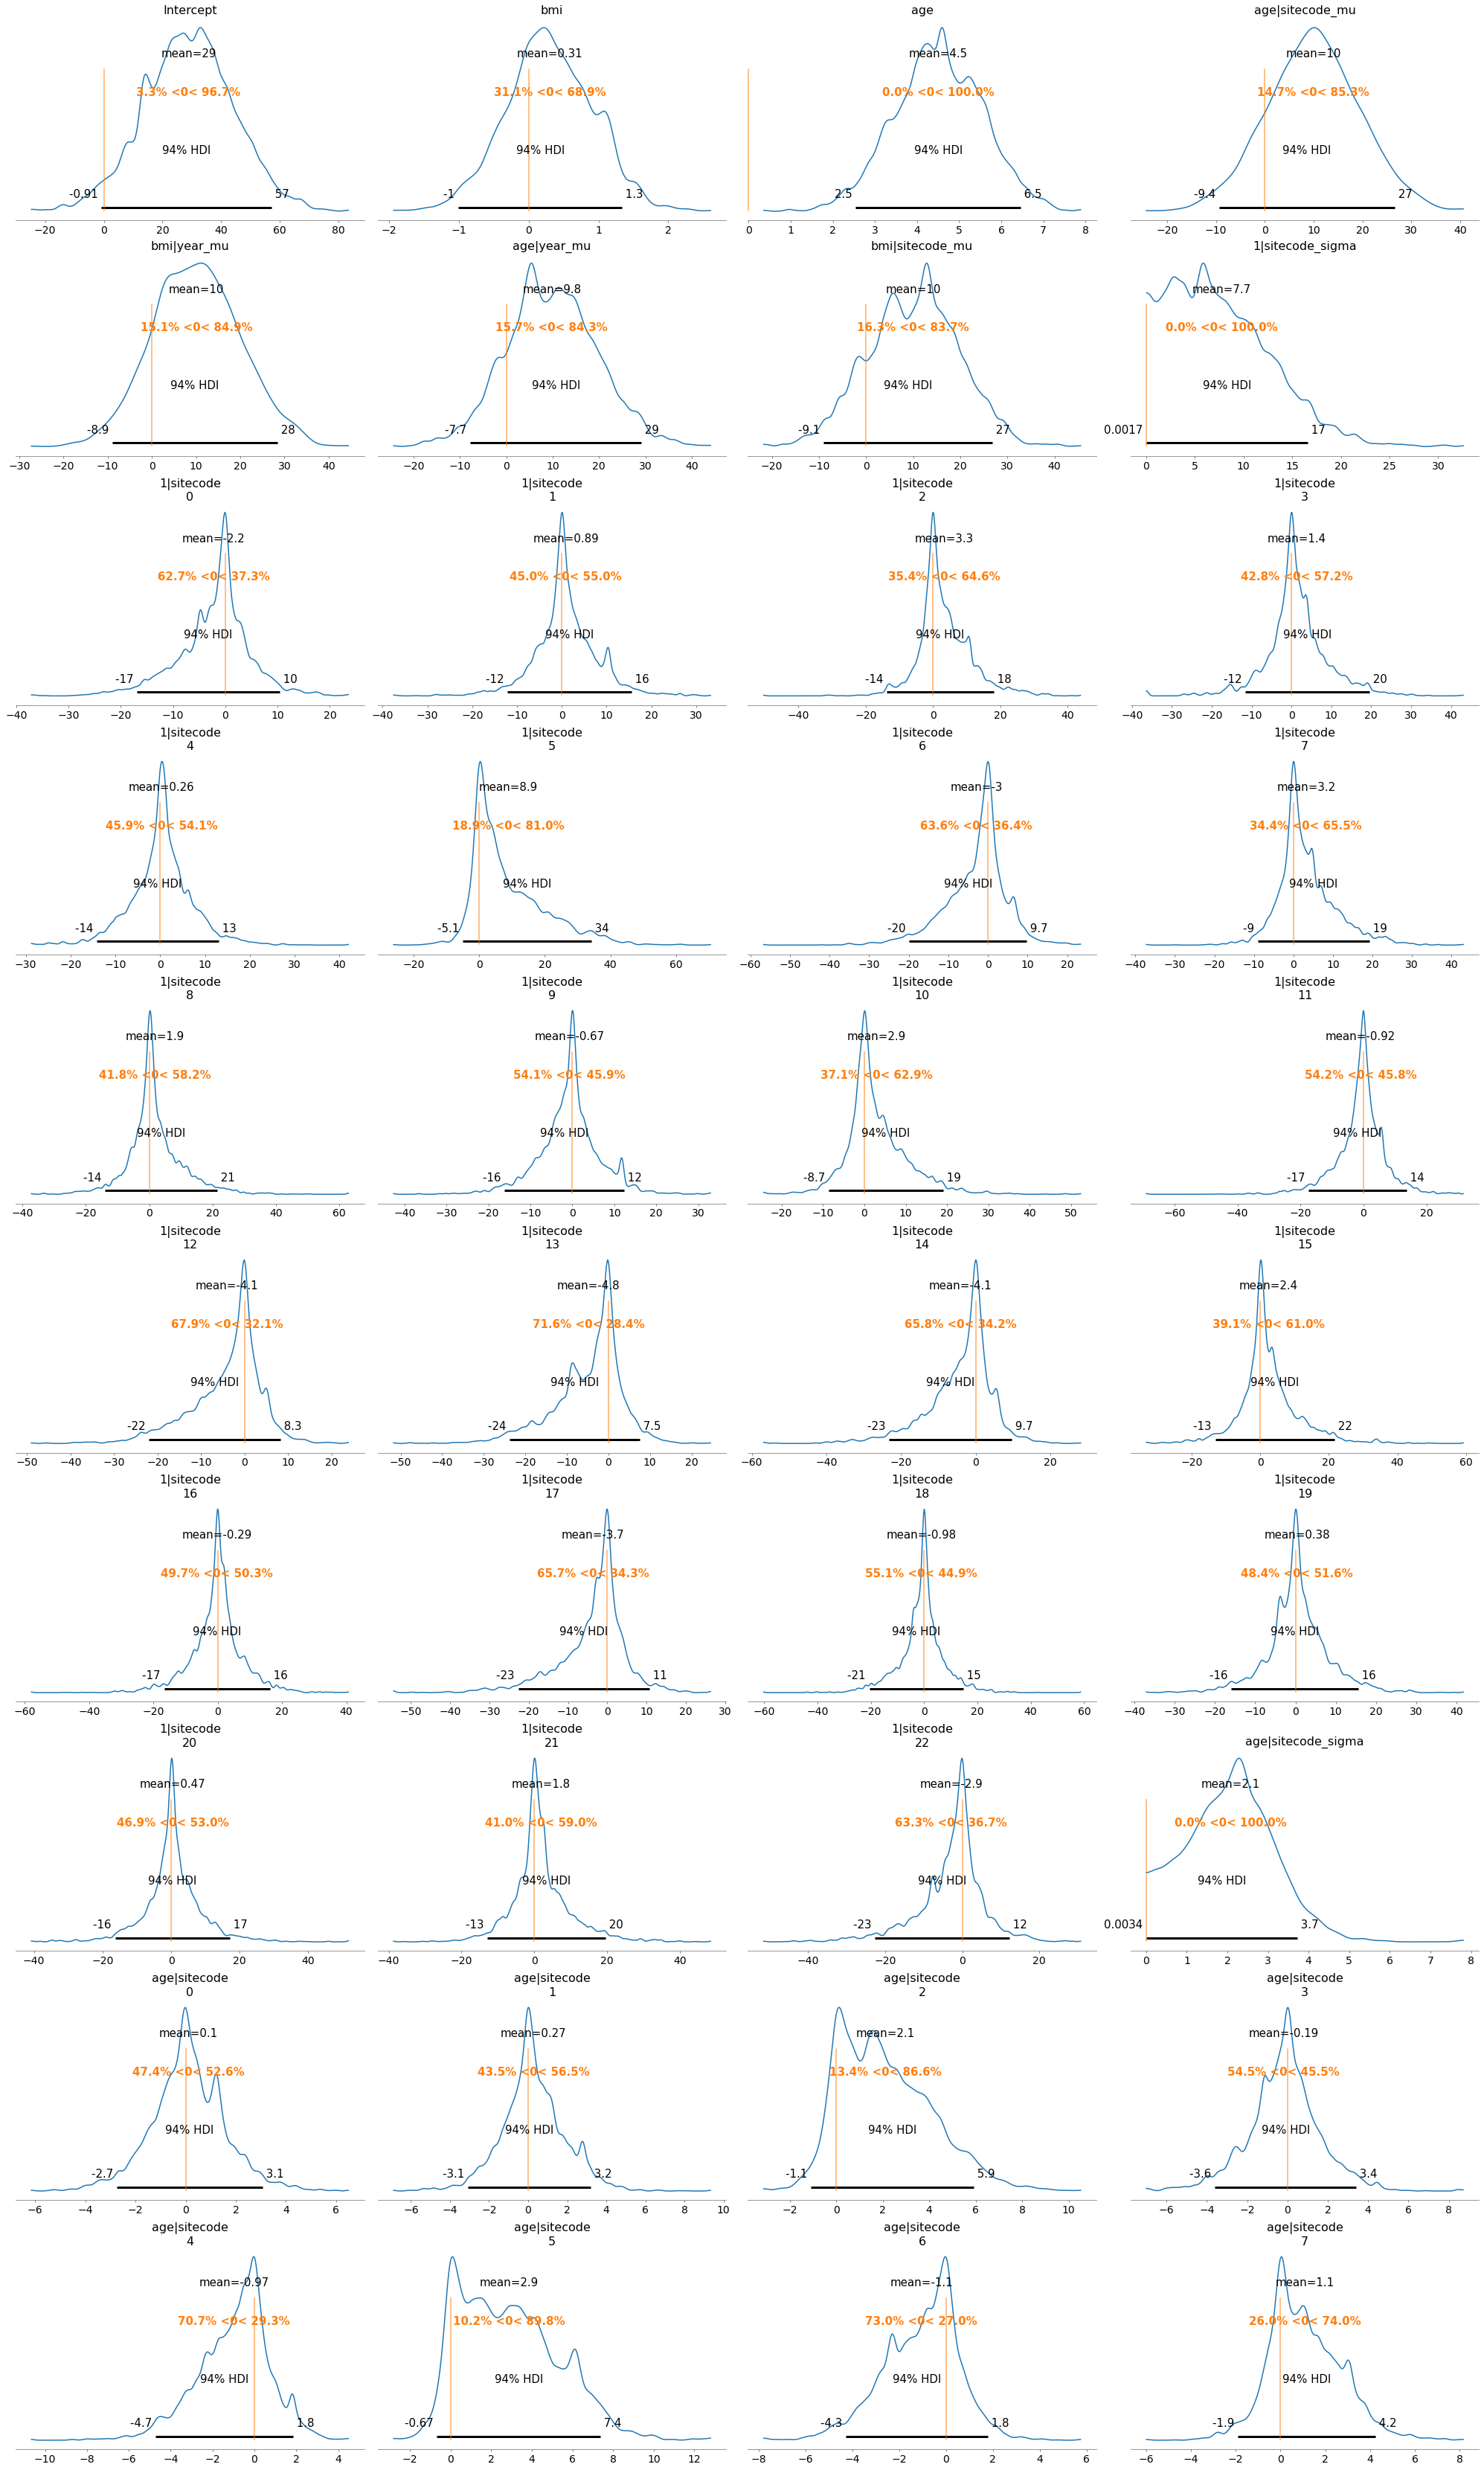

In [54]:
az.plot_posterior(results, ref_val=0);

# Prediction<a class="anchor" id="prediction"></a>
[back to top](#content)

In [ ]:
def test_result(model, )

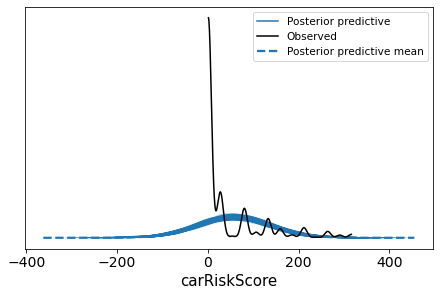

In [61]:
posterior_predictive = model.predict(results, kind="pps", draws=500)
_ = az.plot_ppc(results)

In [64]:
list(results.posterior.data_vars)

['Intercept',
 'bmi',
 'age',
 'age|sitecode_mu',
 'bmi|year_mu',
 'age|year_mu',
 'bmi|sitecode_mu',
 '1|sitecode_sigma',
 '1|sitecode',
 'age|sitecode_sigma',
 'age|sitecode',
 '1|year_sigma',
 '1|year',
 'bmi|year_sigma',
 'bmi|year',
 'age|year_sigma',
 'age|year',
 'bmi|sitecode_sigma',
 'bmi|sitecode',
 'carRiskScore_sigma']

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'bmi'}>,
        <AxesSubplot:title={'center':'bmi'}>],
       [<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'age|sitecode_mu'}>,
        <AxesSubplot:title={'center':'age|sitecode_mu'}>],
       [<AxesSubplot:title={'center':'age|sitecode_sigma'}>,
        <AxesSubplot:title={'center':'age|sitecode_sigma'}>]],
      dtype=object)

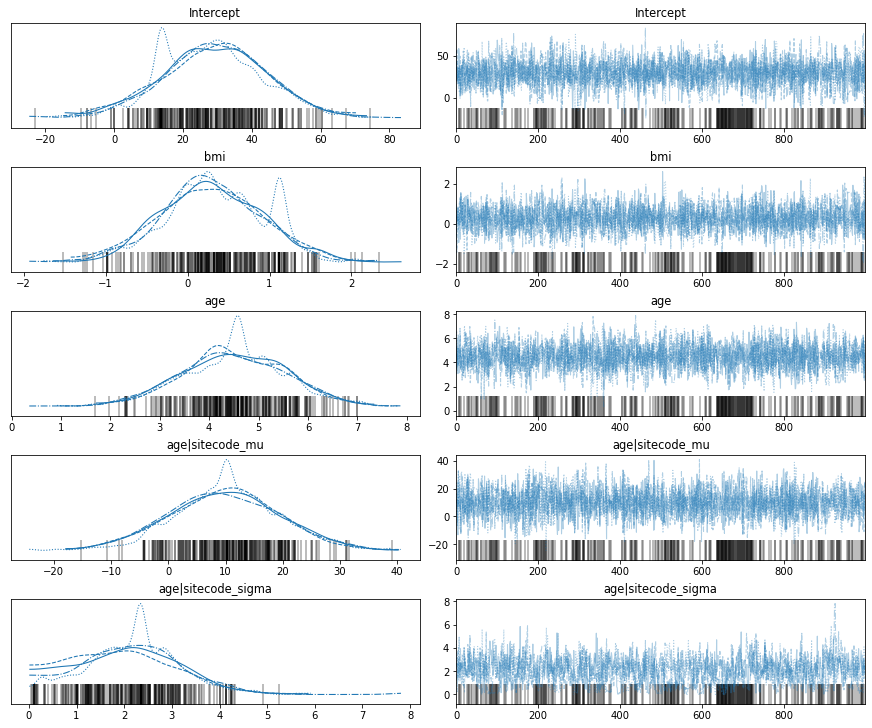

In [66]:
az.plot_trace(results, var_names=['Intercept','bmi','age','age|sitecode_mu',
                                  'age|sitecode_sigma'])

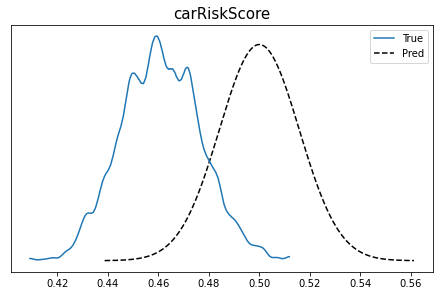

In [78]:
_ = az.plot_bpv(results, kind="p_value")
_ = _.legend(['True','Pred'])

/Users/tangsw/opt/anaconda3/envs/umich/lib/python3.9/site-packages/arviz/plots/plot_utils.py:490: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (101) in plot_autocorr, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'bmi'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'age|sitecode_mu'}>],
       [<AxesSubplot:title={'center':'bmi|year_mu'}>,
        <AxesSubplot:title={'center':'age|year_mu'}>,
        <AxesSubplot:title={'center':'bmi|sitecode_mu'}>,
        <AxesSubplot:title={'center':'1|sitecode_sigma'}>],
       [<AxesSubplot:title={'center':'1|sitecode\n0'}>,
        <AxesSubplot:title={'center':'1|sitecode\n1'}>,
        <AxesSubplot:title={'center':'1|sitecode\n2'}>,
        <AxesSubplot:title={'center':'1|sitecode\n3'}>],
       [<AxesSubplot:title={'center':'1|sitecode\n4'}>,
        <AxesSubplot:title={'center':'1|sitecode\n5'}>,
        <AxesSubplot:title={'center':'1|sitecode\n6'}>,
        <AxesSubplot:title={'center':'1|sitecode\n7'}>],
       [<AxesSubplot:title={'center':'1|sitecode\n8'}>,
        <AxesSubplot:title={'center':'1|sitecode\n9'}>,
        <

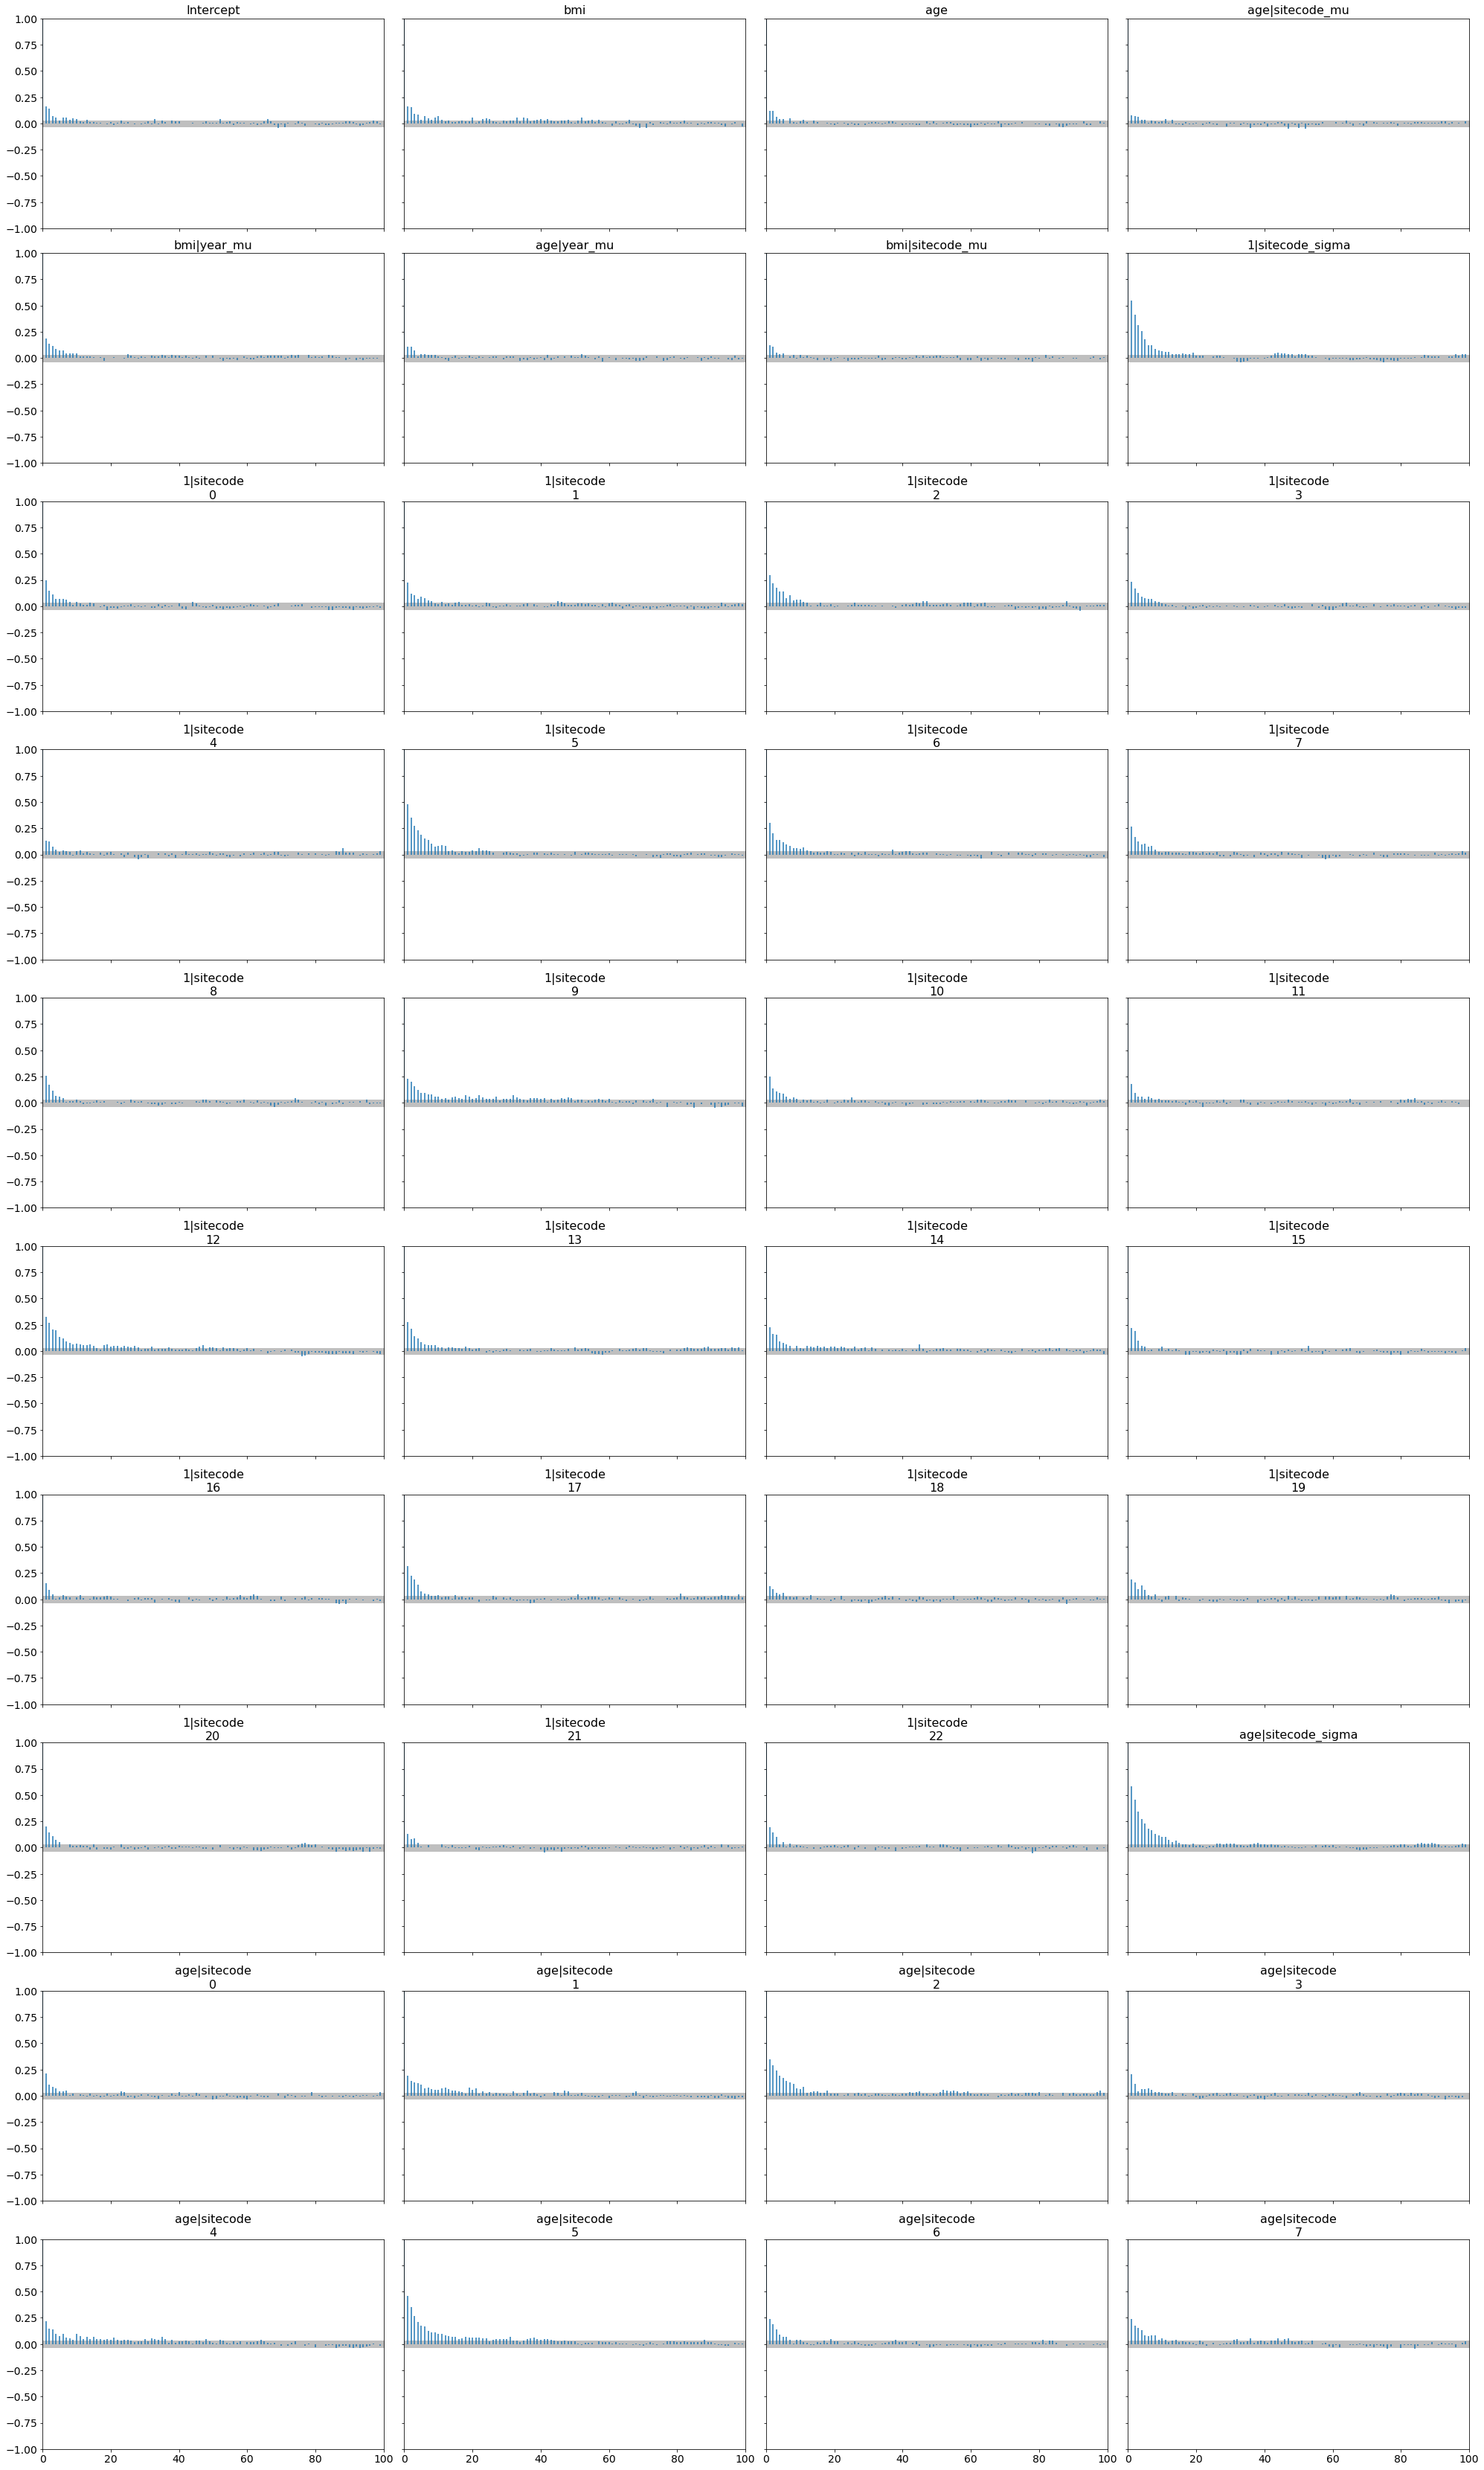

In [80]:
# plot acf
az.plot_autocorr(results, combined=True)

/Users/tangsw/opt/anaconda3/envs/umich/lib/python3.9/site-packages/arviz/plots/plot_utils.py:490: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (101) in plot_rank, generating only 40 plots
  warnings.warn(


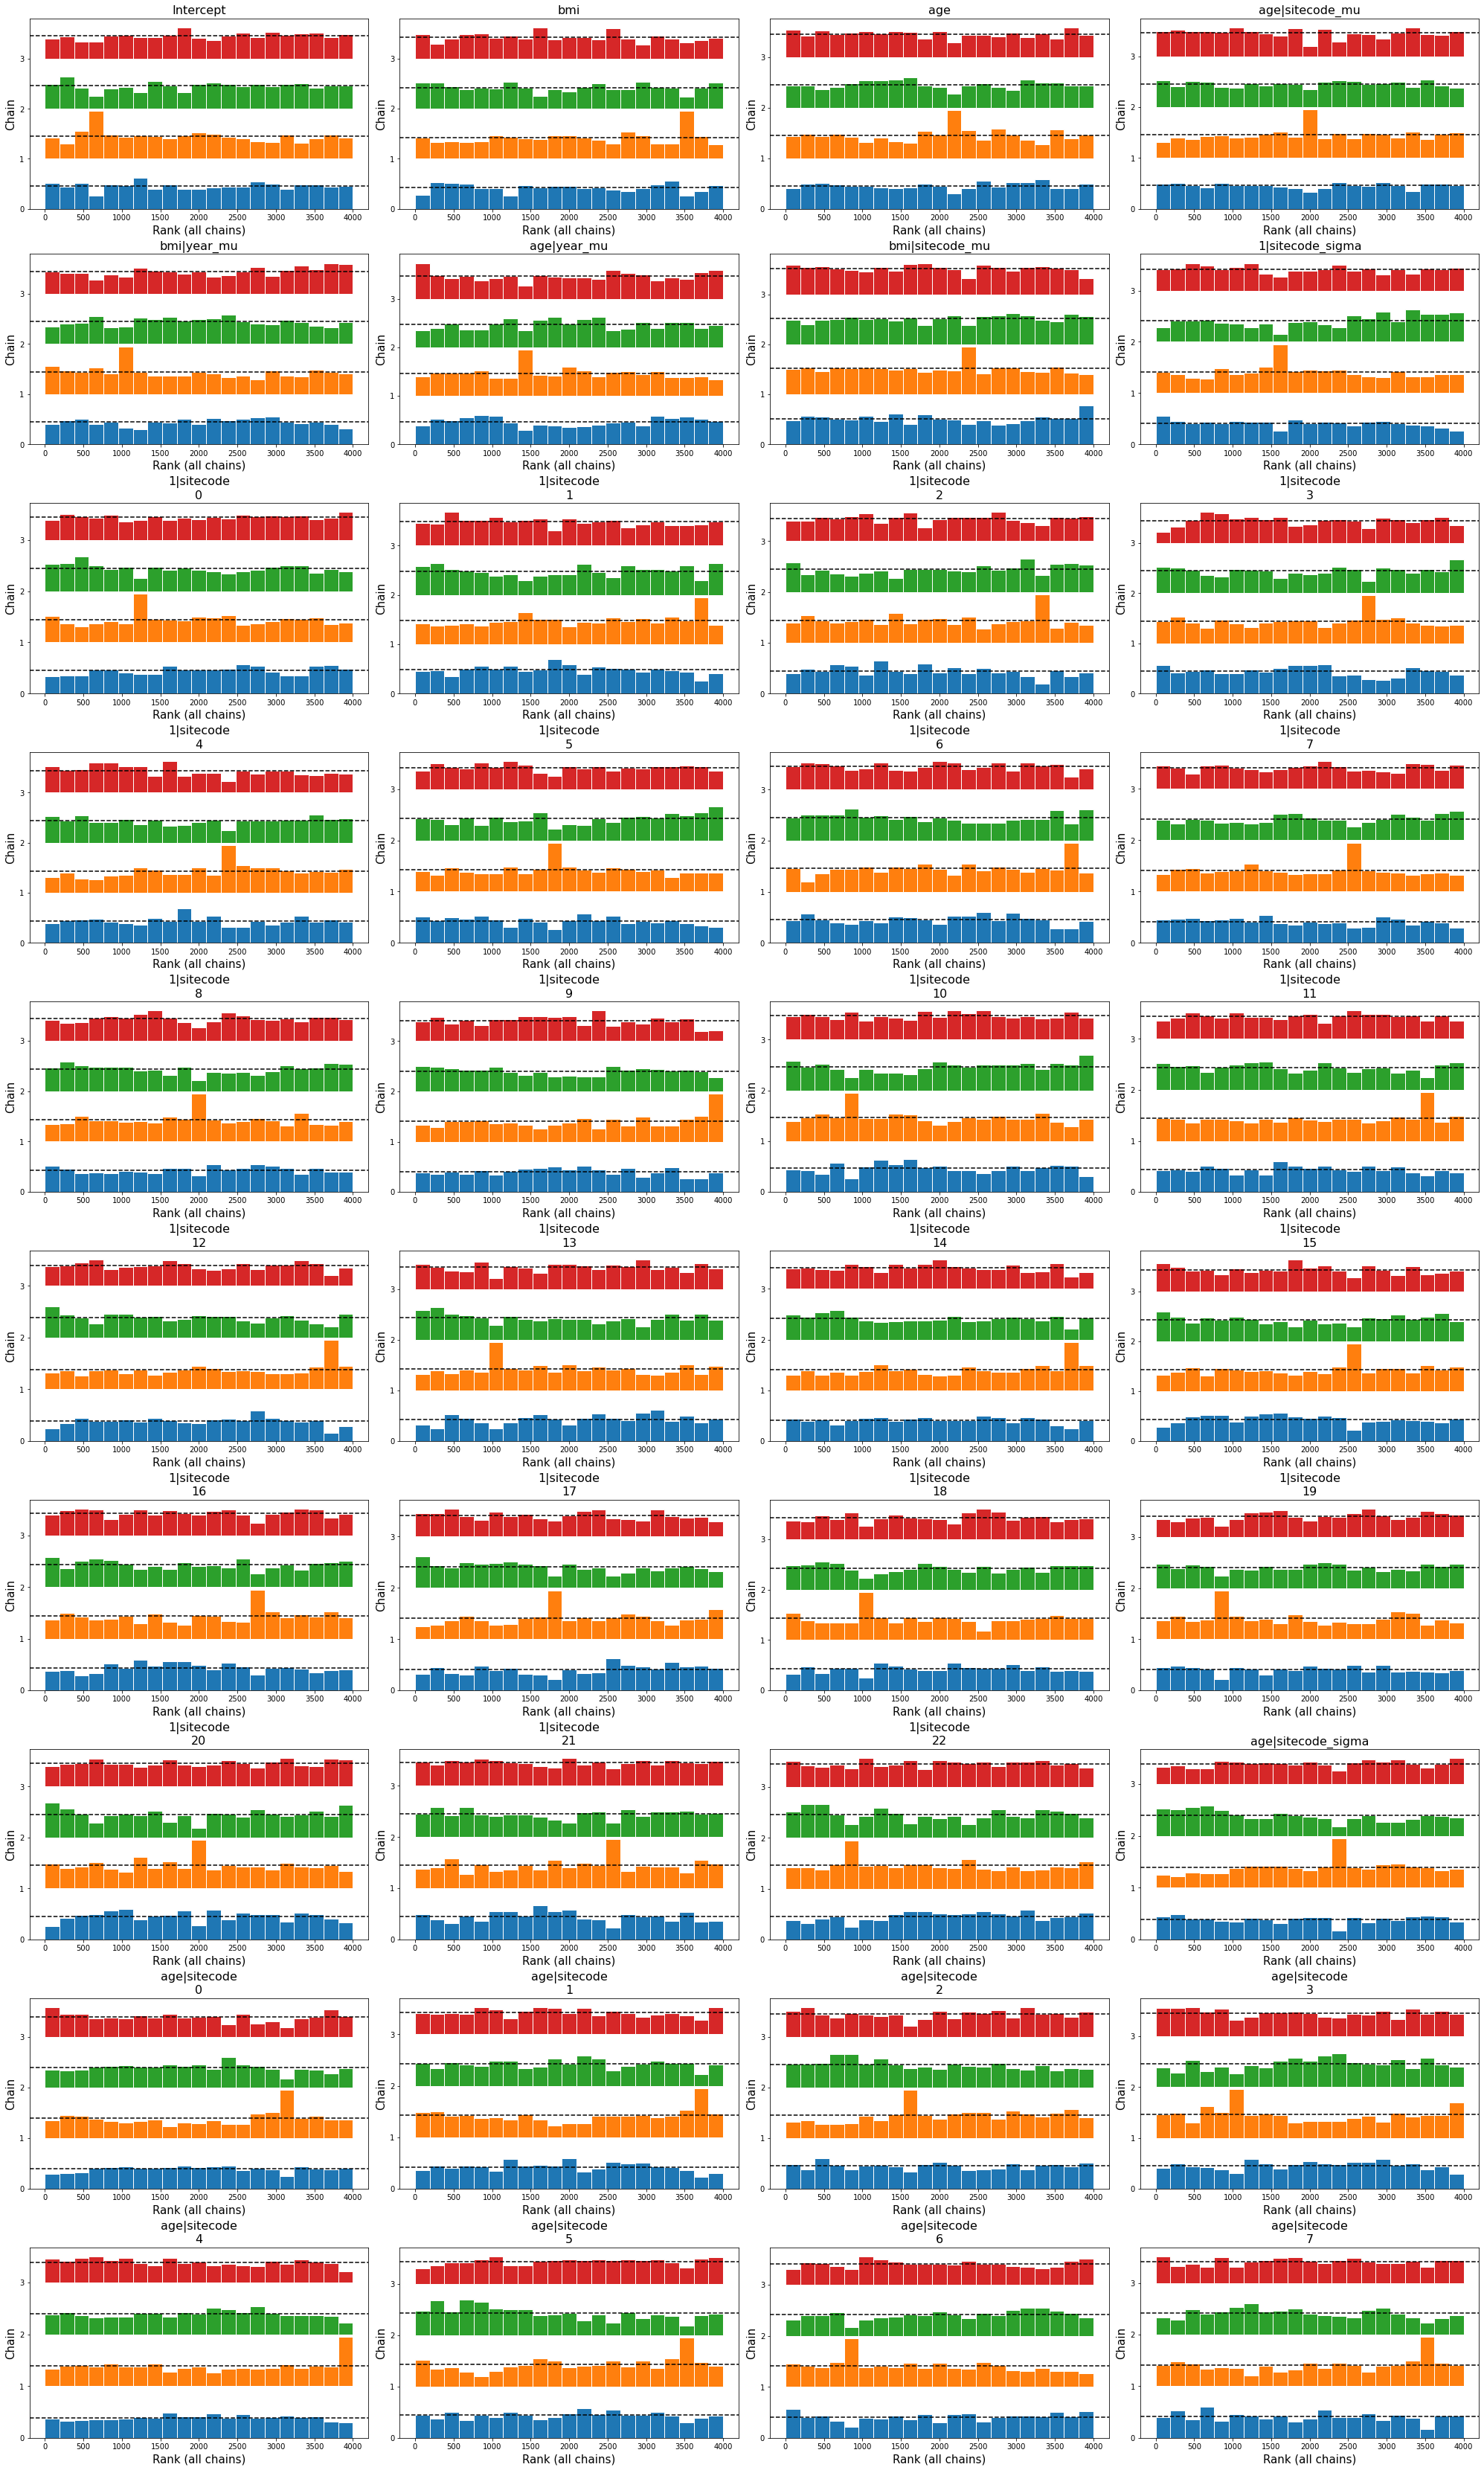

In [82]:
# rank plot
_ = az.plot_rank(results,kind="bars")